In [1]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [2]:
df = pd.read_csv('df.csv')
df.set_index('FIPS');

# Dataset exploration

## Visual exploration

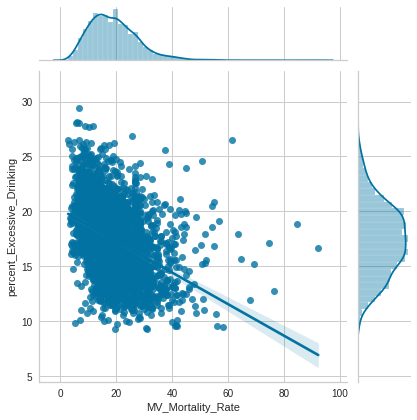

In [3]:
sns.jointplot('MV_Mortality_Rate','percent_Excessive_Drinking', data=df, kind='reg');

- Create graph matrix with [features]

# Feature selection

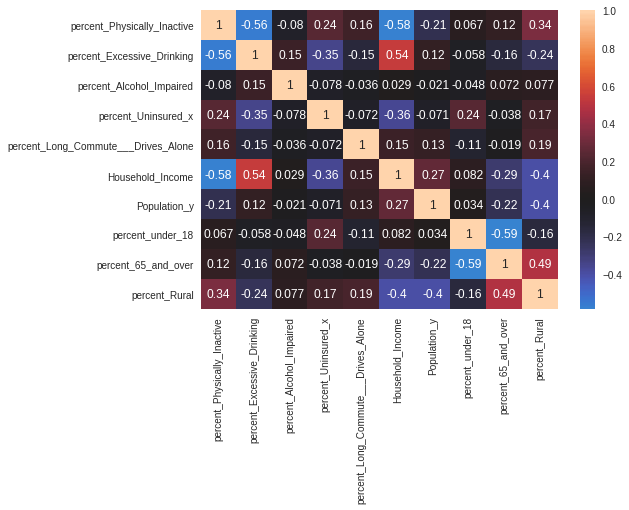

In [4]:
# Original feature list, narrowed down based on vif
# features = ['MV_Mortality_Rate',
#             'Years_of_Potential_Life_Lost_Rate',
#             'percent_Physically_Inactive',
#             'percent_Excessive_Drinking',
#             'percent_Alcohol_Impaired',
#             'percent_Uninsured_x',
#             'Average_Daily_PM25',
#             'percent_Drive_Alone',
#             'percent_Long_Commute___Drives_Alone',
#             'percent_Insufficient_Sleep',
#             'Household_Income',
#             'Population_y',
#             'percent_under_18',
#             'percent_65_and_over',
#             'percent_African_American',
#             'percent_American_Indian_or_Alaskan_Native',
#             'percent_Asian',
#             'percent_Native_Hawaiian_or_Other_Pacific_Islander',
#             'percent_Hispanic',
#             'percent_Non_Hispanic_White',
#             'percent_Not_Proficient_in_English',
#             'percent_Female',
#             'percent_Rural'
#         ]


features = ['MV_Mortality_Rate',
            'percent_Physically_Inactive',
            'percent_Excessive_Drinking',
            'percent_Alcohol_Impaired',
            'percent_Uninsured_x',
            'percent_Long_Commute___Drives_Alone',
            'Household_Income',
            'Population_y',
            'percent_under_18',
            'percent_65_and_over',
            'percent_Rural'
        ]
# MV_Mortality_Rate covers a period of 7 years, by dividing we can get a yearly understanding
# (there is some variation between years but we haven't got that far)
target = df['MV_Mortality_Rate']/7
dfFeatures = df[features].drop(columns='MV_Mortality_Rate')
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

In [5]:
dfFeatures.corr()

,percent_Physically_Inactive,percent_Excessive_Drinking,percent_Alcohol_Impaired,percent_Uninsured_x,percent_Long_Commute___Drives_Alone,Household_Income,Population_y,percent_under_18,percent_65_and_over,percent_Rural
percent_Physically_Inactive,1.000000,-0.562618,-0.079836,0.238215,0.160794,-0.577904,-0.213562,0.066505,0.118582,0.337525
percent_Excessive_Drinking,-0.562618,1.000000,0.146072,-0.348184,-0.150775,0.539503,0.116615,-0.057803,-0.162691,-0.237913
percent_Alcohol_Impaired,-0.079836,0.146072,1.000000,-0.078359,-0.035783,0.029019,-0.020938,-0.048225,0.071929,0.077000
percent_Uninsured_x,0.238215,-0.348184,-0.078359,1.000000,-0.071670,-0.360481,-0.071082,0.237631,-0.038399,0.167953
percent_Long_Commute___Drives_Alone,0.160794,-0.150775,-0.035783,-0.071670,1.000000,0.150340,0.125439,-0.110645,-0.019270,0.189173
Household_Income,-0.577904,0.539503,0.029019,-0.360481,0.150340,1.000000,0.271010,0.081873,-0.287534,-0.396200
Population_y,-0.213562,0.116615,-0.020938,-0.071082,0.125439,0.271010,1.000000,0.034003,-0.215731,-0.395285
percent_under_18,0.066505,-0.057803,-0.048225,0.237631,-0.110645,0.081873,0.034003,1.000000,-0.587180,-0.159456
percent_65_and_over,0.118582,-0.162691,0.071929,-0.038399,-0.019270,-0.287534,-0.215731,-0.587180,1.000000,0.485344
percent_Rural,0.337525,-0.237913,0.077000,0.167953,0.189173,-0.396200,-0.395285,-0.159456,0.485344,1.000000


In [6]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

[('percent_Physically_Inactive', 35.54570813157014),
 ('percent_Excessive_Drinking', 38.79668742722354),
 ('percent_Alcohol_Impaired', 4.91961887492608),
 ('percent_Uninsured_x', 7.610705649820923),
 ('percent_Long_Commute___Drives_Alone', 9.816175466985127),
 ('Household_Income', 32.952387713752),
 ('Population_y', 1.3881167153094347),
 ('percent_under_18', 49.8298787087958),
 ('percent_65_and_over', 22.463061937688472),
 ('percent_Rural', 8.287009034616409)]

# SciKit Baseline model

## Baseline modelling

In [7]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2356 786 2356 786


In [9]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluating the baseline model

In [10]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

fit_time 0.009353542327880859
score_time 0.00232696533203125
test_r2 0.49598654710149004
train_r2 0.5023338274598208
test_neg_mean_squared_error -0.8321782426054968
train_neg_mean_squared_error -0.8201031407874669


In [11]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

The coefficient for percent_Physically_Inactive is 0.18236
The coefficient for percent_Excessive_Drinking is -0.04499
The coefficient for percent_Alcohol_Impaired is 0.04753
The coefficient for percent_Uninsured_x is 0.2108
The coefficient for percent_Long_Commute___Drives_Alone is 0.05258
The coefficient for Household_Income is -0.21915
The coefficient for Population_y is -0.04576
The coefficient for percent_under_18 is 0.29698
The coefficient for percent_65_and_over is 0.11152
The coefficient for percent_Rural is 0.48421
----------------------
The intercept is 2.723747214690111


In [12]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

Train Mean Squarred Error: 0.8212659953514022
Train Rsquared:0.501546593853755


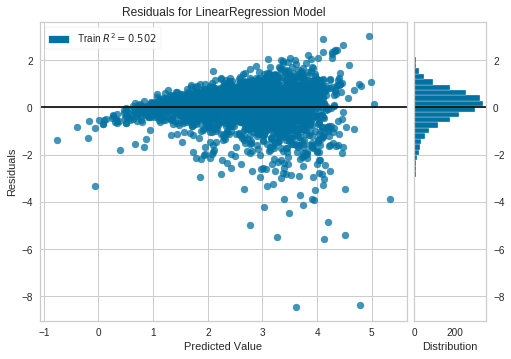

In [24]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();

This graph tells us there is a bias and it is heteroscedastic (higher predicted values have more variance)

# Overfitting the model

In [13]:
# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

# Standardisation
X_poly_s = scaler.fit_transform(X_poly)

# Modellisation
model = LinearRegression()
lin_reg_1 = model.fit(X_poly_s,y_train)

# Evaluation
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared: {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

Rsquared: 0.6411292451761765


# Reducing the fit: LASSO, Ridge and Elastic net regressions

### Hyper parameter tuning

In [23]:
# ridge = Ridge()
# # alpha was narrowed down manually
# ridge_params = {'alpha' : np.linspace(503,505)}

# grid = GridSearchCV(estimator = ridge, 
#                     param_grid = ridge_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 503.81633
## Rsquared: 0.52342

# pd.DataFrame(grid.cv_results_) give the detail of the cross validation results for all the alpha values

KeyboardInterrupt: 

In [15]:
# lasso = Lasso()
# # alpha was narrowed down manually
# lasso_params = {'alpha' : np.linspace(.004, .005)}

# grid = GridSearchCV(estimator = lasso, 
#                     param_grid = lasso_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.00469
## Rsquared: 0.52799

alpha: 0.00469
Rsquared: 0.52799


In [16]:
# enet = ElasticNet()
# # alpha was narrowed down manually
# elastic_params = {'alpha' : np.linspace(0, .5)}

# grid = GridSearchCV(estimator = enet, 
#                     param_grid = elastic_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.0102
## Rsquared: 0.52825

alpha: 0.0102
Rsquared: 0.52825


In [17]:
ridge = Ridge(alpha=503.81633)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)

enet = ElasticNet(alpha=0.0102)
enet.fit(X_poly_s, y_train)

# The following coefficients are transformed and scaled
# (as they work on the _poly_ data)
print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)
print('----------------------')
print('Elastic net parameter coefficients:', enet.coef_)

LinearRegression parameter coefficients: [ 0.1823552  -0.04498776  0.04752823  0.21080244  0.0525807  -0.21915116
 -0.04575683  0.29697762  0.11152051  0.48421046]
----------------------
Ridge parameter coefficients: [ 0.00000000e+00  2.99888164e-02 -3.78678249e-02  4.29079045e-03
  1.44632403e-02  1.16886103e-02 -3.69217120e-02 -1.05979962e-02
  9.41032261e-03  3.12682647e-02  4.73729125e-02  3.36285298e-02
 -3.04307110e-02  6.58773444e-03  1.71229590e-02  1.52727066e-02
 -2.73897631e-02 -1.32182963e-02  3.54393005e-02  1.63381051e-02
  4.42485755e-02 -1.41328256e-02  2.87393234e-03  2.48753548e-02
 -1.25531470e-02 -6.86281002e-03 -7.28292078e-03 -9.70828120e-03
 -1.26651757e-03  1.37981062e-02 -1.13608104e-02  7.98458327e-03
  1.34233833e-02 -1.33447338e-02  2.36350017e-04  1.11424538e-02
  2.14865465e-03  2.05311432e-02 -1.67171460e-02  2.07048792e-02
 -8.47628347e-03 -9.87214948e-03  1.79066221e-02  2.52194484e-02
  1.04178134e-02  4.62918656e-03 -1.75632507e-02  4.67701696e-03
  1

# Testing the model

Training score: 0.5604116754987079
Testing score: 0.5643265991025366


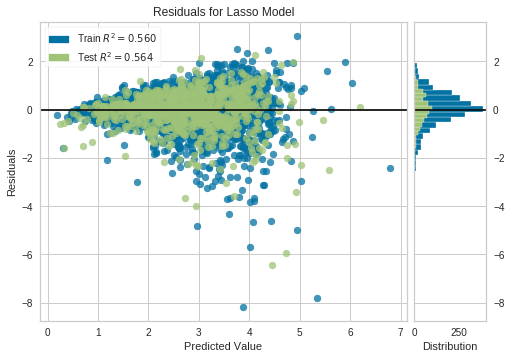

In [22]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Testing score: {lasso.score(X_test_poly_s,y_test)}')
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_poly_s, y_train)
visualizer.score(X_test_poly_s, y_test)
visualizer.show();

In [ ]:
# y_hat_test = lasso.predict(X_test)
# test_mse = mean_squared_error(y_test, y_hat_test)

## Model accuracy

In [ ]:
# result = lasso.score(X_test, y_test)
# print("Accuracy: %.2f%%" % (result*100.0))

## Homoscedasticity check

In [ ]:
fig = qqplot(lasso.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
sns.scatterplot(model.predict(X_train), model.resid)
sns.scatterplot(model.predict(X_train), [0 for i in range(len(X_train))])